In [1]:
import pandas as pd
import numpy as np

<h3> Loading the data </h3>

The task in this dataset is to predict mile-per-gallon (mpg) of cars based on these below features

1. cylinders: multi-valued discrete
2. displacement: continuous
3. horsepower: continuous
4. weight: continuous
5. acceleration: continuous
6. model year: year of the model. Should this be a class feature or numeric feature?
7. origin: this is a class column and thus need to be encoded (three values represent US, Asia, and Europe)

In [2]:
auto = pd.read_csv('auto-mpg.csv')
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleratioin,year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


Train/Test split - we will just use random split

In [3]:
X = auto.drop('mpg',axis=1)
y = auto['mpg']

from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.25)

trainX.shape, testX.shape, trainY.shape, testY.shape

((298, 7), (100, 7), (298,), (100,))

Some descriptive statistics

In [4]:
trainX.describe()

,cylinders,displacement,horsepower,weight,acceleratioin,year,origin
count,298.000000,298.000000,295.000000,298.000000,298.000000,298.000000,298.000000
mean,5.332215,185.773490,102.125424,2915.278523,15.643289,76.174497,1.627517
std,1.667788,102.088625,38.084598,834.967396,2.738546,3.752856,0.823997
min,3.000000,68.000000,46.000000,1613.000000,8.500000,70.000000,1.000000
25%,4.000000,98.750000,75.000000,2206.250000,14.000000,73.000000,1.000000
50%,4.000000,140.000000,90.000000,2720.000000,15.500000,76.000000,1.000000
75%,6.000000,250.000000,115.000000,3463.500000,17.175000,79.750000,2.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


There are a few missing in horsepower, so we need to impute them

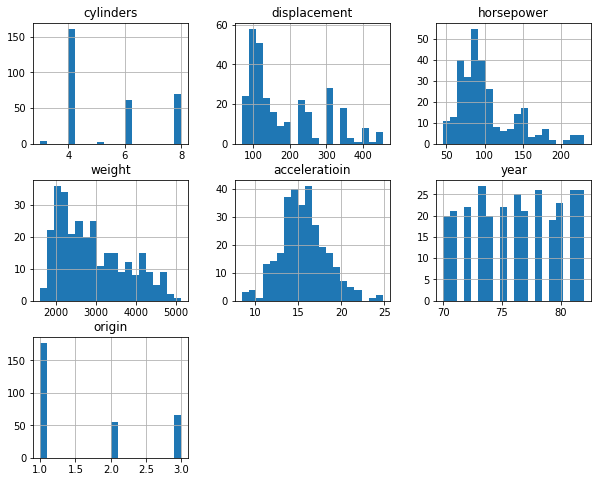

In [5]:
from matplotlib import pyplot as plt

trainX.hist(bins=20, figsize=(10,8))
plt.show()

Some skewed data, so we may want a log-transformation

Statistics on the target:

In [6]:
trainY.describe()

count    298.000000
mean      24.034564
std        7.821996
min        9.000000
25%       18.000000
50%       23.850000
75%       29.975000
max       46.600000
Name: mpg, dtype: float64

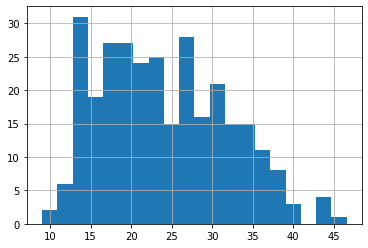

In [8]:
trainY.hist(bins=20)
plt.show()

And scatter plots for all features vs. target

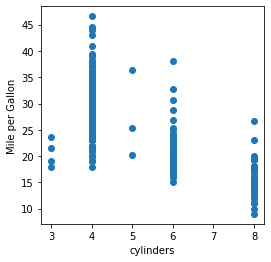

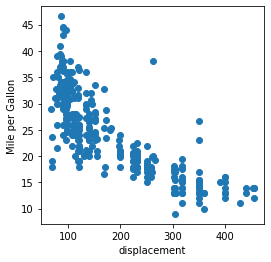

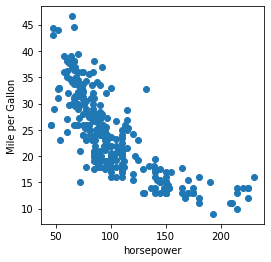

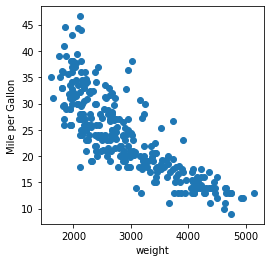

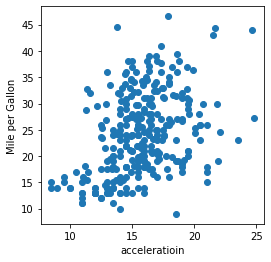

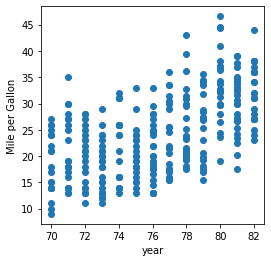

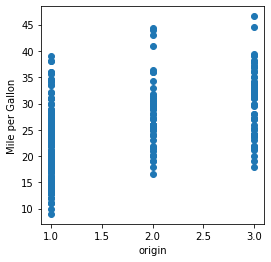

In [19]:
for col in trainX.columns:
    plt.figure(figsize=(4,4))
    plt.scatter(trainX[col], trainY)
    plt.xlabel(col)
    plt.ylabel('Mile per Gallon')
    plt.show()

You can see some strong patterns between mpg and features. Some seems like a curve, so log and squared transformation may be good

<h3> Preprocessing </h3>

First, let's try not having the log or squared features. We also have one class column, so we need to use OneHotEncoder

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#pipeline for numeric features
#we need to impute horsepower
num_cols = trainX.columns[:-1] #because the last column is class
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

#pipeline for class features
cat_cols = trainX.columns[-1:] #because the last column is class
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

#full pipeline - combine numeric and class pipelines
full_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, num_cols),
    ('class', cat_pipeline, cat_cols)
])

In [11]:
trainX_prc = full_pipeline.fit_transform(trainX)
trainX_prc.shape

(298, 9)

<h3> Modeling </h3>

Now we try the models, first, linear regression

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linear_reg = LinearRegression()
linear_reg.fit(trainX_prc,trainY)

mse_lr_cv = - cross_val_score(linear_reg, trainX_prc, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(linear_reg, trainX_prc, trainY, cv=5, scoring='r2')

print('MSE: ', mse_lr_cv.mean())
print('R2: ', r2_lr_cv.mean())

MSE:  11.81538152912382
R2:  0.8019535664971557


an R2 of 0.8 means this model explains 80% of the variations in the miles-per-gallon which is not bad.

Let's try Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
rf_reg.fit(trainX_prc, trainY)

mse_rf_cv = - cross_val_score(rf_reg, trainX_prc, trainY, cv=5, scoring='neg_mean_squared_error')
r2_rf_cv = cross_val_score(rf_reg, trainX_prc, trainY, cv=5, scoring='r2')

print('MSE: ', mse_rf_cv.mean())
print('R2: ', r2_rf_cv.mean())

MSE:  8.22809972305084
R2:  0.8610223959877323


Random forest outperforms linear regression in this data. its R2 is 0.85

<h3> Adding More Input Features </h3>

As discussed, we saw some curve patterns in the scatter plots. It might be benefit for models (especially linear regression) to include the log and squared versions of the features. We will need a different pipeline

In [14]:
def feature_transform(X):
    logX = np.log(X + 0.001)
    sqrX = X**2
    return np.c_[X,logX,sqrX]

In [15]:
from sklearn.preprocessing import FunctionTransformer

num_pipeline_2 = Pipeline([
    ('impute', SimpleImputer()),
    ('log and sqr transform', FunctionTransformer(feature_transform, validate=False)),
    ('standardize', StandardScaler())
])

#we can reuse the class pipeline from before because it didn't change
full_pipeline_2 = ColumnTransformer([
    ('numeric', num_pipeline_2, num_cols),
    ('class', cat_pipeline, cat_cols)
])

In [16]:
trainX_prc_2 = full_pipeline_2.fit_transform(trainX)

And refit the models

In [17]:
linear_reg = LinearRegression()
linear_reg.fit(trainX_prc_2,trainY)

mse_lr_cv = - cross_val_score(linear_reg, trainX_prc_2, trainY, cv=5, scoring='neg_mean_squared_error')
r2_lr_cv = cross_val_score(linear_reg, trainX_prc_2, trainY, cv=5, scoring='r2')

print('MSE: ', mse_lr_cv.mean())
print('R2: ', r2_lr_cv.mean())

MSE:  7.91973461569232
R2:  0.8698258816573942


As you can see, the R2 of linear regression improved considerably - possibly important if we want to make prediction.

How about random forest?

In [18]:
rf_reg = RandomForestRegressor()
rf_reg.fit(trainX_prc, trainY)

mse_rf_cv = - cross_val_score(rf_reg, trainX_prc_2, trainY, cv=5, scoring='neg_mean_squared_error')
r2_rf_cv = cross_val_score(rf_reg, trainX_prc_2, trainY, cv=5, scoring='r2')

print('MSE: ', mse_rf_cv.mean())
print('R2: ', r2_rf_cv.mean())

MSE:  8.670065406949146
R2:  0.8567322373710089


... Not particularly better, which is understandable. Random forests are already robust in terms of dealing with non-linearity in data, so it doesn't benefit from these transformation.